<a href="https://colab.research.google.com/github/PyxAI/Data-Science-Notebooks/blob/master/DCGAN_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DCGAN on Cars and STL datasets!

Hi, I'm glad you came to visit!

After Stanford's CS231n course, I constructed the network for STL. I worked on improving the results by trial and error, and following guidelines from the the following sources:

Alec Radford, Luke Metz & Soumith Chintala on DCGAN:
[UNSUPERVISED REPRESENTATION LEARNING
WITH DEEP CONVOLUTIONAL
GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/abs/1511.06434)

Ian Goodfellow: NIPS 2016 Tutorial,
Generative Adversarial Networks https://arxiv.org/pdf/1701.00160.pdf

and with help from [Jason Brownlee](machinelearningmastery.com)'s excellent website

And: [Tricks of GANS](https://lanpartis.github.io/deep%20learning/2018/03/12/tricks-of-gans.html)

[Cars](https://ai.stanford.edu/~jkrause/papers/3drr13.pdf) [dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) taken with regards from:

3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

---
**This project includes:**

•  DCGAN architecture

•  Auxilary classifier

•  weight vizualization during training


**Techniques I used:**

• Deep CNN Generator and Discriminator

• No dense layers (except the classifier)

• No Pooling layers, only strided convolutions

• Auxiliary classifier

• Batchnorm + Dropout

• LeakyReLU activation

• normalize color datasets to values [-1 : 1]

• double discriminator step 


-TODO

1.   Occasional label flip
3.   Gaussian dist init
5.   Extract label earlier
6.   Incoroprate [faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)




---


#Here are some results that I got
![Cars dataset](https://i.imgur.com/ZDfDQSo.png)
![Cars dataset](https://i.imgur.com/HKaYas0.png)

Watch 100 epochs in 30 seconds [here](https://i.imgur.com/l2Kr7Y9.gifv)

#How to run

Start by going choosing your settings in the **settings** cell.

The default should be just fine, but you can play with the parameters to see their effect on the results!

Run the cells up to the actual training cell, where you will be seeing a live preview of how to generator is doing, as well as activation maps.

-Note that if you want to train from scratch, do not load external weights, or if you did, just reset weights before trainning again.

In [0]:
#@title Imports
%%capture

import random
import os
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from IPython.display import clear_output
import numpy as np
import seaborn as sns
import scipy.io
from google.colab.files import download

import pickle

from math import sqrt, ceil, trunc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from PIL import Image

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

do_cuda = torch.cuda.is_available()


In [0]:
#@title Settings

#Choose your dataset!
#Cars dataset will be resized to dim*dim
sets=('cars','stl')
chosen_set='cars' 

batch_size = 32
training_time = 120 # in minutes, estimated
lr_g = 0.0002 # Generator learning rate, 0.0002
lr_d = 0.0002 # Discriminator learning rate, 0.0002
betas_g = (0.5, 0.999) # Generator betas
betas_d = (0.5, 0.999) # Discriminator betas

double_dis_step = 0 # Train discriminator twice

cache_resized_images = False # Whether or not to resize car images in advance (or on the fly = False)
load_saved_dataset = False # In gdrive
load_saved_weights = True # In gdrive

dep = 64 # depth of discriminator weights multiplier

dis_batchnorm_momentum = 0.1
gen_batchnorm_momentum = 0.1

# Label smoothing because stl classifies too well
smooth_disc_loss = any([chosen_set =='stl'])

#To show only a subset of the filter weights
PREV_LIMIT = 10 
dtype = torch.cuda.FloatTensor if accelerator=='cu80' else torch.FloatTensor
label_dtype = torch.cuda.LongTensor if accelerator=='cu80' else torch.LongTensor

transforms_stl = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])

transforms_crs = T.Compose([
    T.Resize((96,96)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

if load_saved_dataset:
  from google.colab import drive
  drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#@title helper functions
  
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)


def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)


def initialize_weights_rgb(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)


def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.
    """
    noise=torch.rand(batch_size,dim,1,1)
    noise=(noise-0.5)*2
    return noise

def save_image(img, epoch, iter):
    img=img.reshape([3,96,96])
    img=np.transpose(img, (1, 2, 0))
    img= (img+1)/2
    plt.imsave("image_at_epoch_{:04d}_iter_{:04d}.png".format(epoch, iter), img)


In [0]:
#@title Visualization class and functions
"""
Plots X sets of y images conveniently on screen.

uses a grid of w*h for displaying up to w*h images.
adjust the sizes to select which cells to draw the images to, in the format:
[row start, row end, col start, col end, title pos]
"""
class vis():
  def __init__(self, title, w=15, h=10):
    self.fig = plt.figure(figsize = (w, h))
    self.fig.suptitle(title)
    self.images = []
    self.cols = 12 # max images per row
    self.rows = 7
    self.sizes = [[0,2,0,3,0.25,0.92], [0,2,4,7,0.5,0.92], [0,2,8,11,0.75,0.92],\
                  [3,5,0,3,0.25,0.2], [3,5,4,7,0.5,0.2], [3,5,8,11,0.75,0.2]\
                  ] #Hardcoded because its too much work for automatic placement

  """
  Input:  images: array\tensor shaped either:
    N images, -1
    N images, W, H, C 
  title: for the subplots block  
  colors: 3 \ 1 if rgb or not
  """
  def add_images(self, tensor, title, colors=3):
    spread = np.floor(np.sqrt(len(tensor)))
    self.images.append({'data':tensor, 'len':len(tensor), \
                        'title':title, 'spread': spread, 'colors':colors})

  # Calls build_one with the position
  def _build(self):
    self.gs = self.fig.add_gridspec(self.rows,self.cols)
    self.gs.update(wspace=0, hspace=0)
    for pos, img in enumerate(self.images):
        self._build_one(img,self.sizes[pos]) #column row -> row end , column start -> column end


  #Arranges the input and positions it in the allocated space
  def _build_one(self, images, sizes):
    #Get positions from hardcoded list
    x1, x2, y1, y2, title_x_pos, title_y_pos  = sizes

    #Get color and title for the block
    colors = images['colors']
    title = images['title']
    plt.figtext(title_x_pos,title_y_pos,title, va="top", ha="center", size=15)

    # images flattening to (# of images, any dim size)
    images_shaped = np.reshape(images['data'],[images['data'].shape[0], -1])
    image_iter = iter(images_shaped)

    #Get size of image h\w
    sqrtimg = int(np.ceil(np.sqrt(images_shaped[0].shape[0]/colors)))
    #Now building the block
    for i in range(x1, x2+1):
      for j in range(y1, y2+1):
        img = next(image_iter)
        img = (img+1)/2 # Adjust to range 0..1
        ax = self.fig.add_subplot(self.gs[i,j])
        plt.axis('off')
        if colors==3:
          img=img.reshape([3,sqrtimg,sqrtimg])
          img=np.transpose(img, (1, 2, 0))
        else:
          img = img.reshape([sqrtimg,sqrtimg])
        plt.imshow(img)

  def save(self, epoch, iter):
      plt.savefig("image_at_epoch_{:04d}_iter_{:04d}.png".format(epoch, iter))

  def display(self):
    self._build()
    plt.show()

  def getfig(self):
    return self.fig

def gen_mappings(module, input, output):
  global gen_map
  if len(gen_map)==number_of_layers_gen:
    gen_map = []
  gen_map.append(input[0][0].detach().cpu())


def dis_mappings(module, input, output):
  global dis_map
  if len(dis_map)==number_of_layers_dis:
    dis_map = []
  dis_map.append(input[0][0].detach().cpu())



#Image display on a grid
def show_images(images, title="Image", colors=3):
    images = np.reshape(images,[images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/colors)))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    fig.suptitle(title, fontsize=15)
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    for i, img in enumerate(images):
        img = (img+1)/2
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if colors==3:
          img=img.reshape([3,sqrtimg,sqrtimg])
          img=np.transpose(img, (1, 2, 0))
        else:
          img = img.reshape([sqrtimg,sqrtimg])
        plt.imshow(img)

def show_image(img, colors=3):
    sqrtimg = int(np.ceil(np.sqrt(img.shape[0]/colors)))
    img=(img+1)/2
    if colors==3:
      img=np.transpose(img, (1, 2, 0))
    plt.grid(False)
    plt.imshow(img)


In [0]:
#@title Cars dataset class
%%capture

class cars(torch.utils.data.Dataset):
  def __init__(self, imgs_path, labels_path, transform=None):
    super().__init__()
    self.transform = transform
    self.path = imgs_path
    self.images = sorted(os.listdir(imgs_path))
    self.labels = sorted(scipy.io.loadmat(labels_path)['annotations'][0], key=lambda x:x[0])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.path,self.images[idx])
    img = Image.open(img_path, 'r')
    if img.mode=='L':
      img = img.convert(mode='RGB')
    if self.transform:
      img = self.transform(img)
    #Extrating the six labels
    label = self.labels[idx]['class'][0][0]
    return img,label
    


In [0]:
#@title Dataset download and preparation

if chosen_set=='stl':    
    dim=96
    stl_split = 'train+unlabeled'
    epoch_time = 3
    if stl_split =='train':
      NUM_TRAIN = 4500
    else:  
      NUM_TRAIN = 100000
    colors = 3 
    num_of_classes = 10     
    params ={'root':'./stl10/datasets','split':stl_split,  'download':True, 'transform':transforms_stl}
    if load_saved_dataset:
      try: #Loading the model from drive
        with open ('/content/gdrive/My Drive/DCGAN_weights/stl.pkl', 'rb') as f:
          train = pickle.load(f)
      except FileNotFoundError:
        train = dset.STL10(**params)
    else:
      train = dset.STL10(**params)
    #with open ('/content/gdrive/My Drive/DCGAN_weights/stl.pkl', 'wb') as f:
    #pickle.dump(train, f) 


if chosen_set == 'cars':
    dim=96
    epoch_time = 3
    NUM_TRAIN = 16185
    colors = 3  
    num_of_classes = 196
    #Download the cars dataset if doesn't exist
    if load_saved_dataset:
      !mkdir cars
      !cp gdrive/My\ Drive/cars96/* cars
    else:
        if not os.path.exists('cars'):
            print("Downloading the cars dataset")
            !wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz
            !tar zxvf car_ims.tgz -C .
            !rm car_ims.tgz
            !mkdir cars	
            clear_output() 
            print("Cars datset downloaded")
            if cache_resized_images:
              for fname in os.listdir('car_ims'):
                f = os.path.join('car_ims',fname)
                resized_img = Image.open(f,'r').resize((dim,dim))
                resized_img.save('cars/' + fname, "JPEG")
            else:
              !mv car_ims/* cars

    if not os.path.exists('cars_annos.mat'):
        !wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat
 
    train = cars('cars','cars_annos.mat',transforms_crs)

num_epochs = int(np.ceil(training_time / epoch_time))
loader_train = DataLoader(train, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

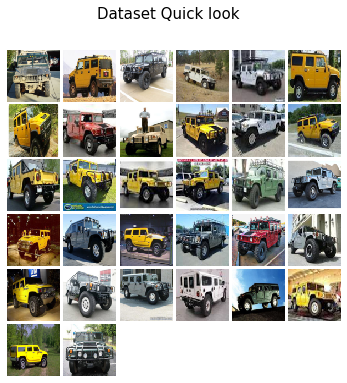

In [0]:
#@title Dataset preview
imgs = loader_train.__iter__().next()[0].view(batch_size, dim*dim*colors).numpy().squeeze()
show_images(imgs, "Dataset Quick look", colors=colors)

Creating the components specified per dataset


In [0]:
#@title Generator networks
%%capture

#Generator * Generator * Generator * Generator * Generator * Generator 
def build_dc_generator(noise_dim=dim):
    return nn.Sequential(
        nn.ConvTranspose2d(dim, dep*16, kernel_size=4, padding=0,stride=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(dep*16, momentum=gen_batchnorm_momentum),
        #nn.Dropout(p=0.5,inplace=True),
        nn.ConvTranspose2d(dep*16, dep*8, kernel_size=4, padding=1,stride=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(dep*8, momentum=gen_batchnorm_momentum),
        nn.Dropout(p=0.5,inplace=True),
        nn.ConvTranspose2d(dep*8, dep*4, kernel_size=4, padding=1,stride=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(dep*4, momentum=gen_batchnorm_momentum),
        nn.Dropout(p=0.5,inplace=True),
        nn.ConvTranspose2d(dep*4, dep*2, kernel_size=4, padding=1,stride=2, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(dep*2, momentum=gen_batchnorm_momentum),
        nn.Dropout(p=0.5,inplace=True),
        nn.ConvTranspose2d(dep*2, dep, kernel_size=4, padding=1,stride=2, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(dep, momentum=gen_batchnorm_momentum),
        #nn.Dropout(p=0.5,inplace=True),
        nn.ConvTranspose2d(dep, 3, kernel_size=4, padding=0,stride=4, bias=False),
        nn.Tanh(),
    )
        
#Generator * Generator * Generator * Generator * Generator * Generator 

In [0]:
#@title Discriminator networks
%%capture
#Discriminator * Discriminator * Discriminator * Discriminator * Discriminator *

def build_dc_base():
    return nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(64, momentum=dis_batchnorm_momentum),
        nn.Dropout(p=0.5,inplace=True),
        nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(64*2,momentum=dis_batchnorm_momentum),
        nn.Dropout(p=0.5,inplace=True),
        nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(64*4,momentum=dis_batchnorm_momentum),
        #nn.Dropout(p=0.2,inplace=True),
        nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.2,inplace=True),
        nn.BatchNorm2d(64*8,momentum=dis_batchnorm_momentum),
        nn.Conv2d(64*8, 1, kernel_size=4, stride=2, padding = 1, bias=False),
    )


def build_dc_discriminator(base):
      return nn.Sequential(
          base,
          nn.Sigmoid()
      )

def build_dc_classifier(base):
      return nn.Sequential(
          base,
          Flatten(),
          nn.Linear(9,num_of_classes)
      )

#Discriminator * Discriminator * Discriminator * Discriminator * Discriminator *

In [0]:
#@title Loss functions
#Loss * Loss * Loss * Loss * Loss * Loss * Loss * Loss * Loss * Loss

"""
Computes the loss for the auxiliary classifier
input: 
  class_labels: PyTorch Variable of shape N, for true labels
  predicted_labels: PyTorch Variable of shape N, for predicted labels
output:
  loss variable
"""
def discriminator_classifier_loss(predicted_labels, class_labels):
    # classifies image labels.
    label_critirion = nn.CrossEntropyLoss()
    class_loss = label_critirion(predicted_labels, class_labels)
    return class_loss


"""
Computes the discriminator loss described above.

Inputs:
- logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
- logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

Returns:
- loss: PyTorch Variable containing (scalar) the loss for the discriminator.
"""
def discriminator_loss(logits_real, logits_fake):    
    # Batch size.
    N = logits_real.size()

    # Target label vector, the discriminator should be aiming
    true_labels = Variable(torch.ones(N)).type(dtype)
    if smooth_disc_loss:
      point2rand = (torch.rand(N, device='cuda')/5)-0.1
      true_labels += point2rand # Smoothing the true labels
    
    # Discriminator loss has 2 parts: how well it classifies
    # real images and how well it classifies fake images.
    real_image_loss = bce_loss(logits_real, true_labels) # All images are real
    fake_image_loss = bce_loss(logits_fake, 1 - true_labels) # All images are fake
    
    loss = real_image_loss + fake_image_loss 
    return loss


"""
Computes the generator loss described above.

Inputs:
- logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

Returns:
- loss: PyTorch Variable containing the (scalar) loss for the generator.
"""
def generator_loss(logits_fake):

    # Batch size.
    N = logits_fake.size()
    
    # Generator is trying to make the discriminator output 1 for all its images.
    # So we create a 'target' label vector of ones for computing generator loss.
    real_or_fake_labels = Variable(torch.ones(N)).type(dtype)
    #point2rand = (torch.rand(N, device='cuda')/5)-0.1
    #real_or_fake_labels += point2rand
    
    # Compute the generator loss compraing 
    loss = bce_loss(logits_fake, real_or_fake_labels)
    
    return loss
  
def bce_loss(input, target):
    loss = nn.BCELoss()
    return loss(input, target)

#Loss * Loss * Loss * Loss * Loss * Loss * Loss * Loss * Loss * Loss


In [0]:
#@title Optimizers 

#Optimizer * Optimizer * Optimizer * Optimizer * Optimizer * Optimizer * Optimizer

def get_optimizer_g(model):
    optimizer = optim.Adam(model.parameters(), lr=lr_g, betas=betas_g)
    return optimizer

def get_optimizer_d(model):
    optimizer = optim.Adam(model.parameters(), lr=lr_d, betas=betas_d)
    return optimizer

def get_optimizer_d_cl(model):
    optimizer = optim.Adam(model.parameters(), lr=lr_d, betas=betas_d)
    return optimizer

#Optimizer * Optimizer * Optimizer * Optimizer * Optimizer * Optimizer * Optimizer

In [0]:
#@title The training function

#title Building the training function
def run_a_gan(dim, D, D_CL, G, D_solver, D_CL_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=batch_size, noise_size=dim, num_epochs=10, double_dis_step=2 ,same_noise = False):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    global loss_tracer_gen
    global loss_tracer_dis
    global epoch
    total_epochs = num_epochs+epoch
    for epoch in range(epoch+1, total_epochs):
        iter_count = 0
        for x, y in loader_train:
            #Put in training mode for dropouts
            G.train()
            D.train()
            if len(x) != batch_size:
                continue
            real_data = Variable(x).type(dtype) # get real images
            labels_real = Variable(y).type(label_dtype)
            # Discriminator learning phase
            D_solver.zero_grad()
            logits_real = D(2* (real_data - 0.5)).type(dtype) # predict on real images
            
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)

            fake_images = G(g_fake_seed).detach() # Generate fake images
            logits_fake = D(fake_images.view(batch_size, colors, dim, dim)) # predict on fake images
            d_total_error = discriminator_loss(logits_real, logits_fake) # Compute the loss
            d_total_error.backward(retain_graph=True)  #Backprop
            D_solver.step() # Be a better observer
            #auxiliary training
            if -1 not in y:
              #print("auxillary training")
              predicted_labels = D_CL(2* (real_data - 0.5)).type(dtype)
              disc_cl_loss = discriminator_classifier_loss(predicted_labels, labels_real)
              disc_cl_loss.backward(retain_graph=True)
              D_CL_solver.step()
            
            # Generator learning phase
            G_solver.zero_grad()

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)

            fake_images = G(g_fake_seed) # Generate fake images
            gen_logits_fake = D(fake_images.view(batch_size, colors, dim, dim)) # Label with discriminator
            g_error = generator_loss(gen_logits_fake) # See how much we fooled the discriminator
            g_error.backward() # Try to fool it better
            G_solver.step() 

            # Make an extra discriminator step every double_dis_step interation
            # use 0 for no extra steps
            if double_dis_step and iter_count % double_dis_step == 0:
                D_solver.zero_grad()
                g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
                fake_images = G(g_fake_seed).detach()
                logits_fake = D(fake_images.view(batch_size, colors, dim, dim))

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_total_error.backward() 
                D_solver.step()

            # Vizualisation
            if (iter_count % show_every == 0):
                G.eval()
                D.eval()
                fake_images = G(g_fake_seed).detach()
                imgs_numpy = fake_images.data.cpu().numpy()
                save_image(imgs_numpy[0],epoch, iter_count)
                # Track changes
                loss_tracer_gen.extend([float(g_error.cpu())])
                loss_tracer_dis.extend([float(d_total_error.cpu())]) 
                title = "Epoch #{}/{}, \nIteration {} | extra discriminator step: {} | batch size: {}\nGenerator error: {:.2f} | Discriminator error: {:.2f}"\
                .format(str(epoch),str(total_epochs), str(iter_count),double_dis_step,batch_size,g_error,d_total_error)
                plotter = vis(title)
                plotter.add_images(imgs_numpy, "random generator seed", 3)
                plotter.add_images(gen_map[2], "Second activation map - gen",colors=1)
                plotter.add_images(gen_map[3], "Third activation map - gen",colors=1)
                plotter.add_images(dis_map[0], "First activation map - Dis",colors=1)
                plotter.add_images(dis_map[1], "Second activation map - Dis",colors=1)
                plotter.add_images(dis_map[2], "Third activation map - Dis", colors=1)
                plotter.display()
                plt.tight_layout()
                plt.show()
                clear_output(wait=True) 
            iter_count += 1


In [0]:
#@title Build the models and reset the weights

#Building base of discriminator
BASE_D = build_dc_base()

#complete discriminator build
D_DC = build_dc_discriminator(BASE_D).type(dtype)
D_DC.apply(initialize_weights)

#building auxiliary classifier
classifier = build_dc_classifier(BASE_D).type(dtype)

#building generator
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

#To show change from the same seed
single_noise = sample_noise(batch_size, dim)
same_seed = Variable(single_noise).type(dtype)

#getting optimizers
D_DC_solver = get_optimizer_d(D_DC)
G_DC_solver = get_optimizer_g(G_DC)
C_DC_solver = get_optimizer_d_cl(D_DC)

loss_tracer_gen = []
loss_tracer_dis = []

epoch = 0

#Registering forward passes for weight vizualisations
gen_map = []
number_of_layers_gen = 0
for module in G_DC.children():
  if isinstance(module, nn.ConvTranspose2d):
    number_of_layers_gen+=1
    module.register_forward_hook(gen_mappings)

dis_map = []
number_of_layers_dis = 0
for module in list(D_DC.children())[0]:
  if isinstance(module, nn.LeakyReLU):
    number_of_layers_dis+=1
    module.register_forward_hook(dis_mappings)

In [0]:
#@title load external weights
%%capture
if load_saved_weights:
  model_load_name = 'dis_cars_waux_wdropout_99.pt'
  epoch_100_disc = "wget -O {} --no-check-certificate 'https://docs.google.com/uc?export=download&id=19cAlRD3fMeE_y9XMlVw_152w4lA2qufC'".format(model_load_name)
  !{epoch_100_disc}
  if do_cuda:
      D_DC.load_state_dict(torch.load(model_load_name)) #To GPU
  else:
      D_DC.load_state_dict(torch.load(model_load_name, map_location=torch.device('cpu')))

  model_load_name = 'gen_cars_waux_wdropout_99.pt'
  epoch_100_gen = "wget -O {} --no-check-certificate 'https://docs.google.com/uc?export=download&id=19b8mcHOq5s4rHn7mvVaUkBvzWjk8-mdH'".format(model_load_name)
  !{epoch_100_gen}
  if do_cuda:
      G_DC.load_state_dict(torch.load(model_load_name)) #To GPU
  else:
      G_DC.load_state_dict(torch.load(model_load_name, map_location=torch.device('cpu')))


In [0]:
#@title Start the training!
if do_cuda:
  G_DC.cuda()
  D_DC.cuda()
run_a_gan(dim,D_DC, classifier, G_DC, D_DC_solver, C_DC_solver, G_DC_solver, discriminator_loss, generator_loss,\
          num_epochs=num_epochs, show_every = 100,\
          double_dis_step = double_dis_step, same_noise =False
          )

NameError: ignored

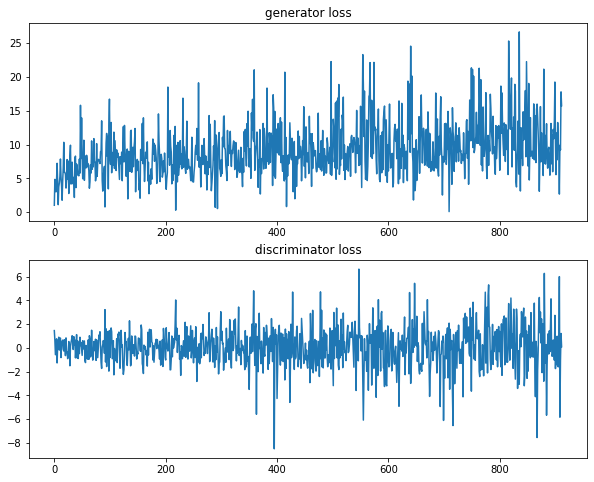

In [0]:
#@title Plot losses

losses = plt.figure()
ax1= plt.subplot(2,1,1)
ax1.plot(loss_tracer_gen)
ax1.set_title("generator loss")

ax2 = plt.subplot(2,1,2)
ax2.plot(loss_tracer_dis)
ax2.set_title("discriminator loss")
losses.savefig("loss.png")
plt.show()


In [0]:
#@title Saving the model to drive

from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'dis_stl_aux_drop{}.pt'.format(epoch)
path = F"/content/gdrive/My Drive/DCGAN_weights/{model_save_name}" 
torch.save(D_DC.state_dict(), path)
print ("saving as {}".format(model_save_name))
model_save_name = 'gen_stl_aux_drop{}.pt'.format(epoch)
path = F"/content/gdrive/My Drive/DCGAN_weights/{model_save_name}" 
torch.save(G_DC.state_dict(), path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
saving as dis_stl_aux_drop37.pt


In my experience, gan's seem to be training very well without batchnorm or dropout, but start to lose performence at later stages of the training (epoch > 40)

Adding dropout doesn't seem to make things worst at first, but eventually the network learns well, but is also more stable now.

The LeakyReLU is important, as ReLU causes generator neurons to zero-out, losing vital information.

adding an auxiliary classifier greatly improves the results, and much faster, the more labels the better

Smoothing the target tensors (giving a score of 0.7-1.2 instead of 1) proved troublesome, lesser quality results.



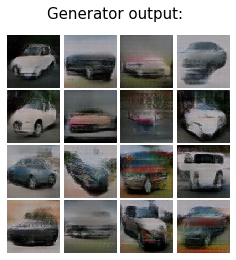

In [0]:
#@title Preview gen
G_DC.eval()
g_fake_seed = Variable(single_noise).type(dtype)
g_fake_seed = Variable(sample_noise(batch_size, dim )).type(dtype)
fake_images = G_DC(g_fake_seed)
imgs_numpy = fake_images.data.cpu().numpy()
show_images(imgs_numpy[0:16], "Generator output:")

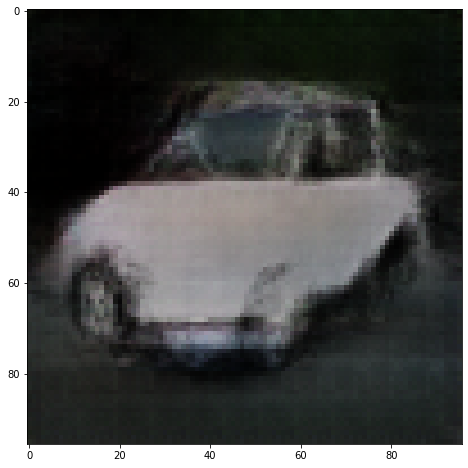

In [0]:
#@title Preview gen extended images
fake_image = G_DC(g_fake_seed[0].reshape(1,96,1,1)).data.cpu().numpy().squeeze()
show_image(fake_image)

Next section used for calculating the size of conv layers

In [0]:
#@title calculations


def conv_trans_calc(in_size, model, pool_f = 2, pool_s = 2, conv_f = 3, conv_s = 2, conv_p = 1):
    out = in_size
    print ('input image:%s*%s'%(out,out))
    for layer in model:
        out = ((out-1)*conv_s) - (2*conv_p) + conv_f
        channels = layer
        print ('itermiediate image:%s*%s*%s'%(out,out,layer))
    output = out * out * channels
    #print (f'Image size after conv is {out}*{out}, channels:{channels}, final vector size:{output}')
    print ('Image size after conv is {%s}*{%s}, channels:{%s}, final vector size:{%s}'%(out,out,channels,output))
    return int(output)

#conv_trans_calc(3,[64*8,64*4,64*2,64,3])

# Hout =(Hin−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

def conv_calc(in_size, model, pool_f = 2, pool_s = 2, conv_f = 5, conv_s = 2, conv_p = 1):
    image_shape = in_size
    for number_of_filters in model:
        if number_of_filters =='M':
            image_shape = trunc(((image_shape - pool_f)/ pool_s) + 1)
        else:
            image_shape = ((image_shape - conv_f + (2 * conv_p))/conv_s) + 1
            channels = number_of_filters
        print ('Intermediate image: %s*%s*%s'%(image_shape,image_shape,channels))
    output = image_shape * image_shape * channels
    print ('Image size after conv is %s*%s, channels:%s, final vector size:%s'%(image_shape,image_shape,channels,output))
    return  int(output)

#conv_calc(27648,[64, 64, 128, 256])

def upconv(layers):
  shape = 1
  for layer in layers:
    shape = (shape-1)*layer['stride']-(2*layer['pad'])+layer['kernel']
    #print(shape)
  return shape*shape

l1 = {"kernel":4, "stride":1, "pad":0}
l2 = {"kernel":4, "stride":1, "pad":1}
l3 = {"kernel":4, "stride":1, "pad":1}
l4 = {"kernel":4, "stride":2, "pad":1}
l5 = {"kernel":4, "stride":2, "pad":1}
l6 = {"kernel":4, "stride":4, "pad":0}

ans = upconv([l1,l2,l3,l4,l5,l6])*3*batch_size

print(ans)
print(ans/96)
print(ans/3)
print(ans/(96*96))
print(ans/(96*96*3*batch_size))



884736
9216.0
294912.0
96.0
1.0


In [0]:
#@title GIF creator

!pip install gif -U
import gif
path= 'car_gif'
files = sorted(os.listdir(path))
frames = []
@gif.frame
def plot(x):
    plt.imshow(plt.imread(os.path.join(path,x)))

for num,im in enumerate(files):
  if num%5:
    frames.append(plot(im))

gif.save(frames, "cars.gif", duration=150)